# QA/QC on CSO data using IQRs and z-scores

## IQR:

$$IQR = Q3-Q1$$

A datapoint is an outlier if:
$$value < Q1 - 1.5 * IQR$$
$$value > Q3 - 1.5 * IQR$$

## z-scores:
$$
z = \frac{value - \mu}{\sigma}
$$

A datapoint is an outlier if:

$$z < -3$$
$$z > 3$$

* threshold could be some number besides 3

In [1]:
import numpy as np 
import pandas as pd
from datetime import date, timedelta
import glob
import geopandas as gpd
import requests
from rasterstats import zonal_stats, point_query

In [2]:
# define directory for tif files
clim_dir = '/nfs/attic/dfh/data/snodas/snodas_tif/clim/'
hs_dir = '/nfs/attic/dfh/data/snodas/snodas_tif/daily_Hs/'

## Get CSO data

In [3]:
domain = 'WY'

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

Bbox = domains[domain]['Bbox']
stn_proj = domains[domain]['stn_proj']
mod_proj = domains[domain]['mod_proj']
stn_proj

'epsg:4326'

In [4]:
st = '2016-10-01'
ed = '2020-06-30'
#Restrict points to the coterminous US
region = {
    'latmax' : 50,
    'latmin' : 25,
    'lonmax': -65,
    'lonmin': -125,}

def get_cso(st, ed, Bbox):

    #Issue CSO API observations request and load the results into a GeoDataFrame
    params = {
      "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
      "start_date": st,
      "end_date": ed,
      "format": "geojson",
      "limit": 5000,
    }

    csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
    csodatajson = csodata_resp.json()
    #turn into geodataframe
    gdf = gpd.GeoDataFrame.from_features(csodatajson, crs='epsg:4326')
    
    mask = (gdf['timestamp'] >= st) & (gdf['timestamp'] <= ed)
    gdf = gdf.loc[mask]
    ingdf=gdf.reset_index(drop=True)
    print('Total number of CSO in domain = ',len(ingdf))
    
    #need to format data for Hs_to_SWE conversion
    ingdf['dt'] = pd.to_datetime(ingdf['timestamp'], format='%Y-%m-%dT%H:%M:%S').dt.date
    #ingdf['dt'] = pd.to_datetime(ingdf['dt']).dt.date
    ingdf['Y'] = pd.DatetimeIndex(ingdf['dt']).year
    ingdf['M'] = pd.DatetimeIndex(ingdf['dt']).month
    ingdf['D'] = pd.DatetimeIndex(ingdf['dt']).day
    ingdf["LON"] = ingdf.geometry.x
    ingdf["LAT"] = ingdf.geometry.y
    ingdf=ingdf.drop(columns=['dt'])
    
    #convert snow depth to mm to input into density function
    ingdf['H'] = ingdf.depth*10

    return ingdf
csodf = get_cso(st, ed, region)

Total number of CSO in domain =  1923


In [5]:
# # temporary test only looking at january data 

# csodf = csodf.loc[(csodf.M==1)]
# csodf.reset_index(inplace= True,drop=True)
# csodf

## IQR flags

In [7]:
def qaqc_iqr(csodf):
    print('Performing qa/qc using IQR method')
    iqr_flag = []
    for i in range(len(csodf)):
        # get cso snow depth
        csohs = csodf.H[i]
        # get date
        dates = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')

        # define path names for 1st and 3rd doy quantiles
        q1_Fname = clim_dir+dates.strftime("%m")+dates.strftime("%d")+'1036q1.tif'
        q3_Fname = clim_dir+dates.strftime("%m")+dates.strftime("%d")+'1036q3.tif'

        q1 = point_query([csodf.geometry[i]], q1_Fname)[0]
        q3 = point_query([csodf.geometry[i]], q3_Fname)[0]
        IQR = q3-q1
        # False = outlier
        iqr_flag.append((csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))

    csodf['iqr_flag'] = iqr_flag
    csodf_clean = csodf.loc[csodf['iqr_flag'] == True]
    csodf_clean = csodf_clean.reset_index(drop=True)
    return csodf_clean

In [8]:
print('Performing qa/qc using IQR method')
iqr_flag = []
for i in range(len(csodf)):
    # get cso snow depth
    csohs = csodf.H[i]
    # get date
    dates = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')

    # define path names for 1st and 3rd doy quantiles
    q1_Fname = clim_dir+dates.strftime("%m")+dates.strftime("%d")+'1036q1.tif'
    q3_Fname = clim_dir+dates.strftime("%m")+dates.strftime("%d")+'1036q3.tif'

    q1 = point_query([csodf.geometry[i]], q1_Fname)[0]
    q3 = point_query([csodf.geometry[i]], q3_Fname)[0]
    IQR = q3-q1
    # False = outlier
    iqr_flag.append((csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))

csodf['iqr_flag'] = iqr_flag

Performing qa/qc using IQR method


/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [9]:
csodf_clean = csodf.loc[csodf['iqr_flag'] == True]
csodf_clean = csodf_clean.reset_index(drop=True)
csodf_clean

geometry        id           author  depth  \
0     POINT (-121.45039 47.35343)  6tqyeB5V      John Soltys   65.0   
1     POINT (-121.50324 46.86279)  wP7MdqQr      John Soltys  175.0   
2     POINT (-121.34462 47.41128)  W4MThBBj      John Soltys  145.0   
3     POINT (-121.66982 44.06474)  Zx5KWtvx      Aaron Hartz  272.0   
4     POINT (-121.66765 44.05888)  8Ok5znz+      Aaron Hartz  145.0   
...                           ...       ...              ...    ...   
1582  POINT (-121.69590 44.02604)  0TYTP3bw      Aaron Hartz  270.0   
1583  POINT (-122.19532 41.40954)  jMRv6Wav   David Cressman  230.0   
1584  POINT (-109.93778 45.05158)  AYENpAjn  Alex Marienthal  225.0   
1585  POINT (-110.91100 45.80707)  Q/EDHi+F      Owen Miller  125.0   
1586  POINT (-111.63863 40.59905)  IcOZ1sT4  Brett  Korpela   130.0   

           source                 timestamp    elevation     Y  M   D  \
0     MountainHub  2020-06-27T16:00:07.750Z  1298.080200  2020  6  27   
1     MountainHub  2020-06-21T18:44:54.760Z  1788.610474  2020  6  21   
2     MountainHub  2020-06-20T15:35:48.245Z  1680.993774  2020  6  20   
3     MountainHub  2020-06-01T18:29:20.110Z  2218.848877  2020  6   1   
4     MountainHub  2020-06-01T17:37:30.260Z  2174.122803  2020  6   1   
...           ...                       ...          ...   ... ..  ..   
1582  MountainHub  2019-02-15T21:32:27.733Z  2027.807373  2019  2  15   
1583    SnowPilot  2019-02-15T21:14:00.000Z  3082.430420  2019  2  15   
1584    SnowPilot  2019-02-15T21:00:00.000Z  2752.135742  2019  2  15   
1585    SnowPilot  2019-02-15T21:00:00.000Z  2051.410156  2019  2  15   
1586    SnowPilot  2019-02-15T20:30:00.000Z  2887.463135  2019  2  15   

             LON        LAT       H  iqr_flag  
0    -121.450390  47.353434   650.0      True  
1    -121.503239  46.862791  1750.0      True  
2    -121.344622  47.411284  1450.0      True  
3    -121.669825  44.064744  2720.0      True  
4    -121.667653  44.058877  1450.0      True  
...          ...        ...     ...       ...  
1582 -121.695898  44.026042  2700.0      True  
1583 -122.195322  41.409543  2300.0      True  
1584 -109.937782  45.051584  2250.0      True  
1585 -110.911000  45.807067  1250.0      True  
1586 -111.638625  40.599054  1300.0      True  

[1587 rows x 14 columns]

In [10]:
snodas_hs = []
iqr_flag = []
q1s = []
q3s = []
IQRs = []
for i in range(len(csodf)):
    print(i)
    # get cso snow depth
    csohs = csodf.H[i]/1000
    # get date
    date = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')
    
    # define path names
    snodas_Fname = hs_dir+'us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.tif'
    q1_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036q1.tif'
    q3_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036q3.tif'

    snodas_hs.append(point_query([csodf.geometry[i]], snodas_Fname)[0])
    q1 = point_query([csodf.geometry[i]], q1_Fname)[0]
    q1s.append(q1)
    q3 = point_query([csodf.geometry[i]], q3_Fname)[0]
    q3s.append(q3)
    IQR = q3-q1
    IQRs.append(q3-q1)
    #print(csohs,q1-1.5*IQR,q3+1.5*IQR,(csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))
    iqr_flag.append((csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))
        
csodf['snodas'] = snodas_hs
csodf['iqr_flag'] = iqr_flag
csodf['q1'] = q1s
csodf['q3'] = q3s
csodf['IQR'] = IQRs

0


/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
csodf

geometry        id           author  depth  \
0     POINT (-121.45039 47.35343)  6tqyeB5V      John Soltys   65.0   
1     POINT (-121.50324 46.86279)  wP7MdqQr      John Soltys  175.0   
2     POINT (-121.34462 47.41128)  W4MThBBj      John Soltys  145.0   
3     POINT (-121.66982 44.06474)  Zx5KWtvx      Aaron Hartz  272.0   
4     POINT (-121.66765 44.05888)  8Ok5znz+      Aaron Hartz  145.0   
...                           ...       ...              ...    ...   
1918  POINT (-122.19532 41.40954)  jMRv6Wav   David Cressman  230.0   
1919  POINT (-109.93778 45.05158)  AYENpAjn  Alex Marienthal  225.0   
1920  POINT (-110.91100 45.80707)  Q/EDHi+F      Owen Miller  125.0   
1921  POINT (-110.91100 48.80707)  +LGczs7z      Owen Miller  125.0   
1922  POINT (-111.63863 40.59905)  IcOZ1sT4  Brett  Korpela   130.0   

           source                 timestamp    elevation     Y  M   D  \
0     MountainHub  2020-06-27T16:00:07.750Z  1298.080200  2020  6  27   
1     MountainHub  2020-06-21T18:44:54.760Z  1788.610474  2020  6  21   
2     MountainHub  2020-06-20T15:35:48.245Z  1680.993774  2020  6  20   
3     MountainHub  2020-06-01T18:29:20.110Z  2218.848877  2020  6   1   
4     MountainHub  2020-06-01T17:37:30.260Z  2174.122803  2020  6   1   
...           ...                       ...          ...   ... ..  ..   
1918    SnowPilot  2019-02-15T21:14:00.000Z  3082.430420  2019  2  15   
1919    SnowPilot  2019-02-15T21:00:00.000Z  2752.135742  2019  2  15   
1920    SnowPilot  2019-02-15T21:00:00.000Z  2051.410156  2019  2  15   
1921    SnowPilot  2019-02-15T21:00:00.000Z  1054.144775  2019  2  15   
1922    SnowPilot  2019-02-15T20:30:00.000Z  2887.463135  2019  2  15   

             LON        LAT       H  iqr_flag       snodas           q1  \
0    -121.450390  47.353434   650.0      True    30.945998     0.000000   
1    -121.503239  46.862791  1750.0      True  1050.834629    98.270990   
2    -121.344622  47.411284  1450.0      True   731.330542     0.000000   
3    -121.669825  44.064744  2720.0      True  1123.576122     0.000000   
4    -121.667653  44.058877  1450.0      True  1088.559132     0.000000   
...          ...        ...     ...       ...          ...          ...   
1918 -122.195322  41.409543  2300.0      True  2916.496784   791.632168   
1919 -109.937782  45.051584  2250.0      True  1446.751060  1682.183497   
1920 -110.911000  45.807067  1250.0      True   817.177217   578.721722   
1921 -110.911000  48.807067  1250.0     False    87.832008     0.000000   
1922 -111.638625  40.599054  1300.0      True  2792.066678  1527.405601   

               q3          IQR  
0      701.385686   701.385686  
1     1459.528478  1361.257488  
2     1779.088473  1779.088473  
3     1386.564229  1386.564229  
4     1414.024713  1414.024713  
...           ...          ...  
1918  2417.879891  1626.247723  
1919  2405.124520   722.941023  
1920   917.455419   338.733696  
1921    69.764016    69.764016  
1922  2428.479940   901.074339  

[1923 rows x 18 columns]

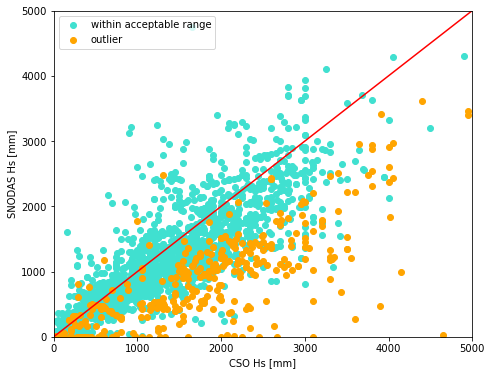

In [10]:
import matplotlib.pyplot as plt
# create data
x = csodf.H[csodf.iqr_flag==True]
y = csodf.snodas[csodf.iqr_flag==True]
x_flag = csodf.H[csodf.iqr_flag==False]
y_flag = csodf.snodas[csodf.iqr_flag==False]

fig, ax = plt.subplots(1,figsize=(7.5,6))
ax.plot(np.arange(0,5000), np.arange(0,5000),'r')
ax.scatter(x, y,c='turquoise',label='within acceptable range')
ax.scatter(x_flag, y_flag,c='orange',label='outlier')
ax.set_ylabel('SNODAS Hs [mm]')
ax.set_ylim([0,5000])
ax.set_xlabel('CSO Hs [mm]')
ax.set_xlim([0,5000])
ax.legend()

In [11]:
fig.savefig("IQR_flag_qaqc.png", dpi=300,bbox_inches='tight')

In [12]:
import folium

In [13]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in csodf.iterrows():
    folium.Marker(location=[row['LAT'], row['LON']], 
                  icon=folium.Icon(color='orange' if row['iqr_flag'] == False else 'blue'),
                  popup="<b>{0} cso:{1:.1f} m</b> snodas:{2:.1f} m</b> Observer: </br>{3} Source: {4}</b> iqr flag: {5}".format(
                      row['timestamp'], row['H'],row['snodas'], 
                      row['author'], row['source'],row['iqr_flag'])
                 ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m

## z-score flags

In [14]:
z_flag = []
snodas_hs =[]
for i in range(len(csodf)):
    #print(i)
    # get cso snow depth
    csohs = csodf.H[i]
    # get date
    date = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')
    
    # define path names
    snodas_Fname = hs_dir+'us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.tif'    
    std_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036std.tif'
    mean_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036mean.tif'

    snodas_hs.append(point_query([csodf.geometry[i]], snodas_Fname)[0])
    std = point_query([csodf.geometry[i]], std_Fname)[0]
    mean = point_query([csodf.geometry[i]], mean_Fname)[0]
    try: 
        z_score = (csohs - mean)/std
        #print(i,std,mean,z_score)
        z_flag.append((z_score > -3) & (z_score < 3))
    except:
        z_flag.append(False)
        
csodf['snodas'] = snodas_hs
csodf['z_flag'] = z_flag

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


In [15]:
csodf

geometry        id          author       depth  \
0     POINT (-121.45039 47.35343)  6tqyeB5V     John Soltys   65.000000   
1     POINT (-121.50324 46.86279)  wP7MdqQr     John Soltys  175.000000   
2     POINT (-121.34462 47.41128)  W4MThBBj     John Soltys  145.000000   
3     POINT (-121.66982 44.06474)  Zx5KWtvx     Aaron Hartz  272.000000   
4     POINT (-121.66765 44.05888)  8Ok5znz+     Aaron Hartz  145.000000   
...                           ...       ...             ...         ...   
2063  POINT (-111.62640 40.67166)  E7XUvxfA    Mark Staples  120.000000   
2064  POINT (-122.27077 47.54969)  S5id1Rny  Anthony Arendt   20.999999   
2065  POINT (-122.19626 41.34717)  wOobCINh   Ryan Sorenson  260.000000   
2066  POINT (-114.35006 46.60694)  vVBiXGMh      Logan King  150.000000   
2067  POINT (-110.92848 45.83082)  JnNmyKxk     Zach Bailey  145.000000   

           source                 timestamp    elevation     Y  M   D  \
0     MountainHub  2020-06-27T16:00:07.750Z  1298.080200  2020  6  27   
1     MountainHub  2020-06-21T18:44:54.760Z  1788.610474  2020  6  21   
2     MountainHub  2020-06-20T15:35:48.245Z  1680.993774  2020  6  20   
3     MountainHub  2020-06-01T18:29:20.110Z  2218.848877  2020  6   1   
4     MountainHub  2020-06-01T17:37:30.260Z  2174.122803  2020  6   1   
...           ...                       ...          ...   ... ..  ..   
2063    SnowPilot  2019-02-04T21:30:00.000Z  2636.939697  2019  2   4   
2064  MountainHub  2019-02-04T21:04:51.267Z    72.866943  2019  2   4   
2065    SnowPilot  2019-02-04T21:00:00.000Z  2171.428955  2019  2   4   
2066    SnowPilot  2019-02-04T20:00:00.000Z  2147.827148  2019  2   4   
2067    SnowPilot  2019-02-04T19:40:00.000Z  2255.771484  2019  2   4   

             LON        LAT            H  iqr_flag       snodas           q1  \
0    -121.450390  47.353434   650.000000      True    30.945998     0.000000   
1    -121.503239  46.862791  1750.000000      True  1050.834629    98.270990   
2    -121.344622  47.411284  1450.000000      True   731.330542     0.000000   
3    -121.669825  44.064744  2720.000000      True  1123.576122     0.000000   
4    -121.667653  44.058877  1450.000000      True  1088.559132     0.000000   
...          ...        ...          ...       ...          ...          ...   
2063 -111.626400  40.671660  1200.000000      True  1223.510208  1057.316922   
2064 -122.270766  47.549687   209.999992     False    16.000000   -81.031896   
2065 -122.196260  41.347170  2600.000000      True  2798.860285  1009.706561   
2066 -114.350057  46.606944  1500.000000      True  1741.106934  1195.115270   
2067 -110.928483  45.830820  1450.000000      True   990.448958   704.195219   

               q3          IQR  z_flag  
0      701.385686   701.385686    True  
1     1459.528478  1361.257488    True  
2     1779.088473  1779.088473    True  
3     1386.564229  1386.564229    True  
4     1414.024713  1414.024713    True  
...           ...          ...     ...  
2063  1492.554054   435.237133    True  
2064   -43.555616    37.476280   False  
2065  2569.699738  1559.993178    True  
2066  1755.325318   560.210048    True  
2067  1205.344905   501.149686    True  

[2068 rows x 19 columns]

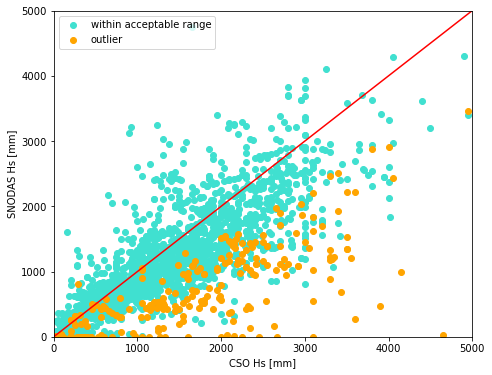

In [16]:
import matplotlib.pyplot as plt
# create data
x = csodf.H[csodf.z_flag==True]
y = csodf.snodas[csodf.z_flag==True]
x_flag = csodf.H[csodf.z_flag==False]
y_flag = csodf.snodas[csodf.z_flag==False]

fig, ax = plt.subplots(1,figsize=(7.5,6))
ax.plot(np.arange(0,5000), np.arange(0,5000),'r')
ax.scatter(x, y,c='turquoise',label='within acceptable range')
ax.scatter(x_flag, y_flag,c='orange',label='outlier')
ax.set_ylabel('SNODAS Hs [mm]')
ax.set_ylim([0,5000])
ax.set_xlabel('CSO Hs [mm]')
ax.set_xlim([0,5000])
ax.legend()

In [17]:
fig.savefig("z-score_flag_qaqc.png", dpi=300,bbox_inches='tight')

In [18]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in csodf.iterrows():
    folium.Marker(location=[row['LAT'], row['LON']], 
                  icon=folium.Icon(color='orange' if row['z_flag'] == False else 'blue'),
                  popup="<b>{0} cso:{1:.1f} m</b> snodas:{2:.1f} m</b> Observer: </br>{3} Source: {4}</b> z flag: {5}".format(
                      row['timestamp'], row['H'],row['snodas'], 
                      row['author'], row['source'],row['z_flag'])
                 ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m